In [1]:
# Importations standard
import time
from datetime import datetime
import json
from itertools import product

import shap
# Importations scientifiques et mathématiques
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Prétraitement des données
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer l'IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

# Modèles et algorithmes
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import xgboost as xgb

# Validation croisée et métriques
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Suréchantillonnage et validation
from imblearn.over_sampling import SMOTE

# Optimisation des hyperparamètres
import optuna

# Pipeline
from sklearn.pipeline import Pipeline

# Profilage des données
from ydata_profiling import ProfileReport


c:\Users\asus\OneDrive\Bureau\Formations\USSBA_Classification\Brief04_USSBA_classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(name):
    df = pd.read_csv(name)
    return df

In [3]:
def data_search_isna(df):
    return df.isna().sum()

In [4]:
def data_remplace_Mode_isna(df):
    # Remplacement par la valeur la plus fréquente (Mode)
    for col in ["State", "BankState", "NewExist", "LowDoc","RevLineCr"]:
        df[col] = df[col].fillna(df[col].mode()[0])

In [5]:
def data_remplace_MIS_STATUS(df):
    # Boucle sur les colonnes spécifiées pour remplir les valeurs manquantes
    for col in ["FranchiseCode", "RevLineCr", "LowDoc"]:
        # Remplacer les valeurs NaN de la colonne 'MIS_Status' par la mode de chaque groupe
        df["MIS_Status"] = df.groupby(col)["MIS_Status"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "PIF"))
    return df

In [6]:
df=load_data("preparation_data.csv")

# Générer un rapport de profilage
#profile = ProfileReport(df, title="Rapport de Profilage", explorative=True)

# Sauvegarder le rapport au format HTML
#profile.to_file("rapport_profilage.html")

# Création des nouvelles variables
recession_years = [2008, 2009, 2020]  # Exemples d'années de récession
df['RecessionPeriod'] = df['ApprovalFY'].apply(lambda x: 1 if x in recession_years else 0)
df['Loan_Usage_Ratio'] = df['DisbursementGross'] / df['GrAppv']
df['Employee_Loan_Ratio'] = df['NoEmp'] / df['GrAppv']
df['JobImpact'] = df['CreateJob'] + df['RetainedJob']

# Variables sélectionnées
num_vars = ['ApprovalFY', 'Term', 'DisbursementGross','UrbanRural', 'GrAppv', 'NoEmp', 'Loan_Usage_Ratio', 'Employee_Loan_Ratio', 'JobImpact']
cat_vars = ['NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'RecessionPeriod','State', 'BankState', 'NAICS_2']#, 'Loan_Term_Category']

data_remplace_Mode_isna(df)
data_remplace_MIS_STATUS(df)

# Regrouper les États en clusters avec KMeans
# Convertir State et BankState en valeurs numériques (Label Encoding)

label_encoders = {}
for col in ["State", "BankState"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # On garde l'encodeur si besoin plus tard

# Appliquer KMeans pour regrouper State et BankState en clusters
for col in ["State", "BankState"]:
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)  # 10 clusters (modifiable)
    df[col + "_Cluster"] = kmeans.fit_predict(df[[col]])

# Supprimer les colonnes originales State et BankState
X = df.drop(columns=["MIS_Status","State", "BankState"])#,"Term"
y = df["MIS_Status"]  # Variable cible
#y = y.fillna(y.mode()[0])

In [7]:
y.isna().sum()

0

Fit train data
SHAP


100%|===================| 89894/89917 [74:22<00:01]        

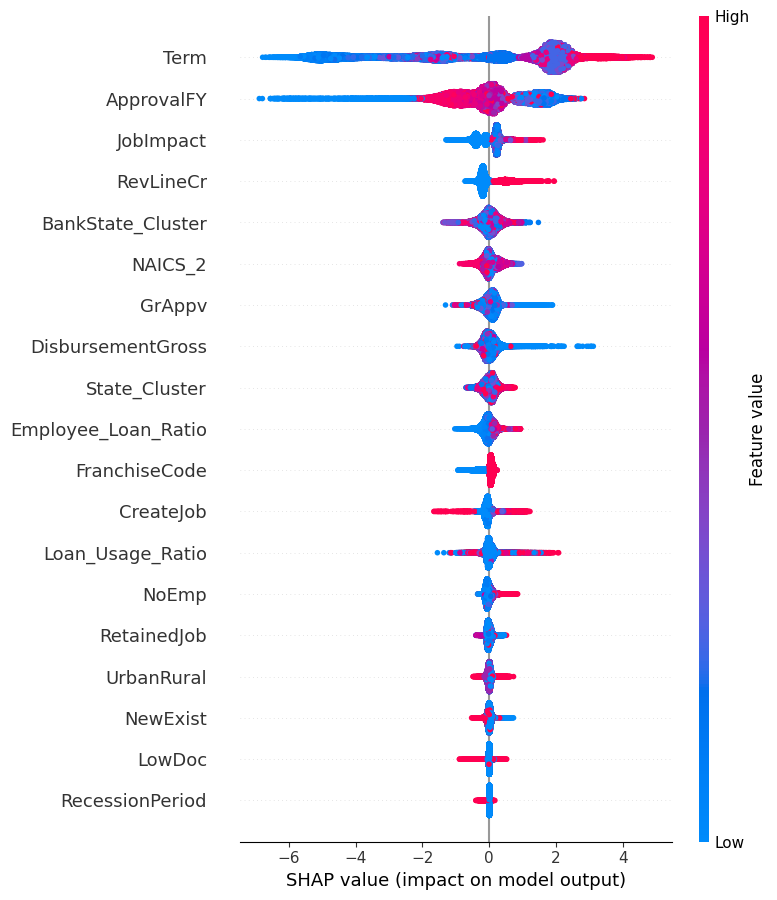

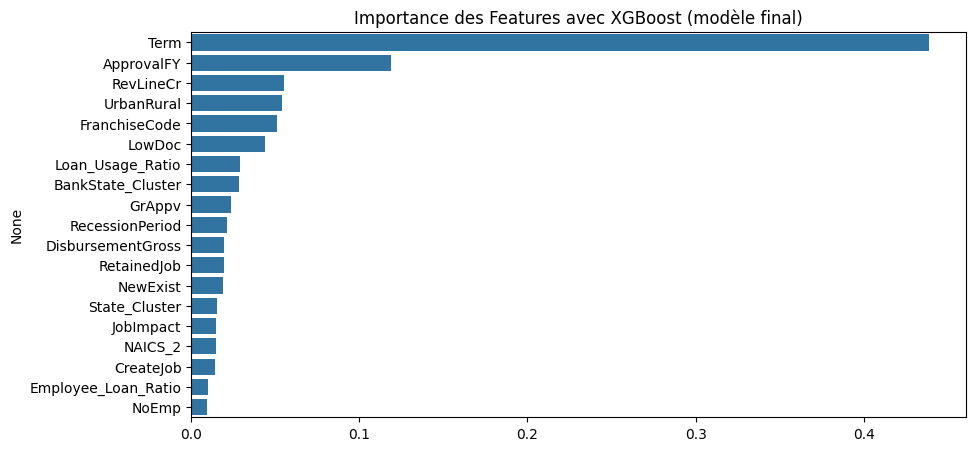


Performances du modèle réduit (sans features moins importantes) :
{'Accuracy': 0.9154220002891555, 'Precision': 0.9507137633068776, 'Recall': 0.9465217567184908, 'F1-Score': 0.9486131288219196, 'AUC': 0.9436596418763662}

Performances du modèle initial (avec toutes les features) :
{'Accuracy': 0.9516887796523461, 'Precision': 0.9738174414658975, 'Recall': 0.9674357141893988, 'F1-Score': 0.9706160880976217, 'AUC': 0.9808307521097335}

Résultats enregistrés dans results_reduced_2025-02-13_12-44-10.json


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Définition de la métrique choisie
chosen_metric = "roc_auc"  # Options : "recall", "precision", "accuracy", "f1", "roc_auc"

# Détection et suppression des outliers avec IsolationForest
use_outlier_detection = False
if use_outlier_detection:
    iso = IsolationForest(contamination=0.05, random_state=42)
    outliers = iso.fit_predict(X_train)
    mask = outliers != -1  # Conserver uniquement les valeurs normales
    X_train, y_train = X_train[mask], y_train[mask]

use_scaling = True
if use_scaling:
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
       
# Transformation polynomiale
use_polynomial_features = False
if use_polynomial_features:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
else:
    X_train_poly, X_test_poly = X_train_scaled, X_test_scaled

# Réduction de dimension avec PCA
use_pca = False
if use_pca:
    pca = PCA(n_components=0.95)  # Garde 95% de la variance
    X_train_pca = pca.fit_transform(X_train_poly)
    X_test_pca = pca.transform(X_test_poly)
else:
    X_train_pca, X_test_pca = X_train_poly, X_test_poly

X_train_fusion = X_train_pca
X_test_fusion = X_test_pca

import matplotlib
# Force le backend Matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
# Définition des meilleurs hyperparamètres
params = {
    "objective": "binary:logistic",  # Objectif de classification binaire
    "eval_metric": "auc",  # AUC comme métrique d'évaluation
    "max_depth": 10,  # Meilleure profondeur maximale de l'arbre
    "learning_rate": 0.08127793890152064,  # Meilleur taux d'apprentissage
    "n_estimators": 301,  # Meilleur nombre d'estimateurs
    "subsample": 0.8998377792872224,  # Meilleure fraction des données pour chaque arbre
    "colsample_bytree": 0.7064372895885673,  # Meilleure fraction des caractéristiques par arbre
    "gamma": 0,  # Meilleure valeur de gamma
    "min_child_weight": 4,  # Meilleur poids minimum des échantillons dans un nœud
    "max_delta_step": 3,  # Meilleur pas maximal pour mise à jour des poids
    "scale_pos_weight": 0.5956065021713672,  # Meilleure balance des classes
    "lambda": 1.8686162524289114,  # Meilleure régularisation L2
    "alpha": 0.22511566813369155,  # Meilleure régularisation L1
    "random_state": 42  # Pour garantir la reproductibilité
}

print("Fit train data")
# Entraînement du modèle
model = xgb.XGBClassifier(**params)
model.fit(X_train_fusion, y_train)

print("SHAP")
# Créer un explainer SHAP
explainer = shap.Explainer(model, X_train_fusion)

# Calculer les valeurs SHAP pour l'ensemble de test
shap_values = explainer(X_test_fusion)

# Visualiser l'importance des caractéristiques
shap.summary_plot(shap_values, X_test_fusion)


# Prédictions sur le jeu de test
y_prob = model.predict_proba(X_test_fusion)[:, 1]

# Vérification des NaN ou valeurs infinies dans y_prob
if np.isnan(y_prob).any():
    print("Attention : Des NaN ont été détectés dans les probabilités.")
if np.isinf(y_prob).any():
    print("Attention : Des valeurs infinies ont été détectées dans les probabilités.")

# Extraction des importances des features
importances = model.feature_importances_
features = X_train_fusion.columns

# Trier les importances et les features en ordre décroissant
sorted_idx = np.argsort(importances)[::-1]  # Indices des importances triées
sorted_importances = importances[sorted_idx]  # Importances triées
sorted_features = features[sorted_idx]  # Features triées

# Affichage des features les plus importantes triées
plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Importance des Features avec XGBoost (modèle final)")
plt.show()

# Choisir un seuil pour supprimer les features les moins importantes
threshold = 0.2  # Seuil d'importance pour supprimer les features
important_features = sorted_features[sorted_importances >= threshold]  # Features importantes

# Créer un nouveau jeu de données sans les features les moins importantes
X_train_reduced = X_train_fusion[important_features]
X_test_reduced = X_test_fusion[important_features]

# Entraîner un modèle sur ce nouveau jeu de données réduit
model_reduced = xgb.XGBClassifier(**params)
model_reduced.fit(X_train_reduced, y_train)

# Prédictions sur le jeu de test
y_prob_reduced = model_reduced.predict_proba(X_test_reduced)[:, 1]

# Calcul des performances sur le jeu de test
fusion_performance_reduced = {
    "Accuracy": accuracy_score(y_test, (y_prob_reduced >= 0.5).astype(int)),
    "Precision": precision_score(y_test, (y_prob_reduced >= 0.5).astype(int), zero_division=0),
    "Recall": recall_score(y_test, (y_prob_reduced >= 0.5).astype(int), zero_division=0),
    "F1-Score": f1_score(y_test, (y_prob_reduced >= 0.5).astype(int), zero_division=0),
    "AUC": roc_auc_score(y_test, y_prob_reduced)
}

# Affichage des résultats du modèle réduit
print("\nPerformances du modèle réduit (sans features moins importantes) :")
print(fusion_performance_reduced)

# Comparaison avec le modèle initial
fusion_performance_initial = {
    "Accuracy": accuracy_score(y_test, (y_prob >= 0.5).astype(int)),
    "Precision": precision_score(y_test, (y_prob >= 0.5).astype(int), zero_division=0),
    "Recall": recall_score(y_test, (y_prob >= 0.5).astype(int), zero_division=0),
    "F1-Score": f1_score(y_test, (y_prob >= 0.5).astype(int), zero_division=0),
    "AUC": roc_auc_score(y_test, y_prob)
}

print("\nPerformances du modèle initial (avec toutes les features) :")
print(fusion_performance_initial)

# Sauvegarde des résultats dans un fichier JSON
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"results_reduced_{timestamp}.json"
results_reduced = {
    "best_params": params,
    "fusion_performance_initial": fusion_performance_initial,
    "fusion_performance_reduced": fusion_performance_reduced,
}

with open(file_name, "w") as f:
    json.dump(results_reduced, f, indent=4)

print(f"\nRésultats enregistrés dans {file_name}")

In [17]:
print(shap_values.shape)

(89917, 19)


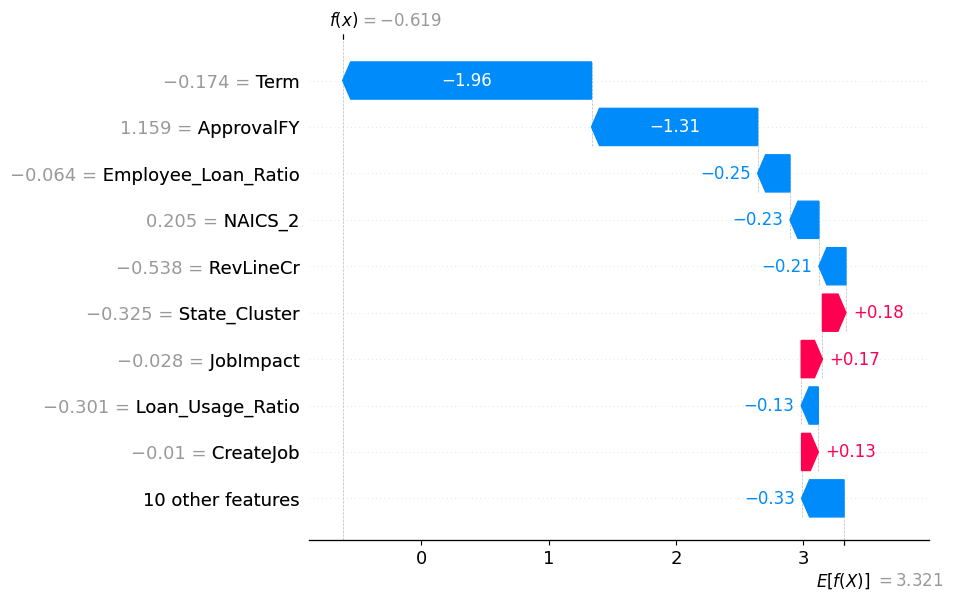

In [15]:
shap.waterfall_plot(shap_values[0])  # Par exemple, pour la première prédiction


In [9]:
# Sauvegarde dans un fichier CSV
df_pred = pd.DataFrame({'y_prob': y_prob})

df_pred.to_csv("predictions.csv", index=False)

print("Les prédictions ont été enregistrées dans predictions.csv")

Les prédictions ont été enregistrées dans predictions.csv


In [10]:
df_pred = pd.DataFrame({'y_test': y_test, 'y_prob': y_prob})
df_pred.to_csv("predictions_comparaison.csv", index=False)

print("Les prédictions et valeurs réelles ont été enregistrées dans predictions_comparaison.csv")


Les prédictions et valeurs réelles ont été enregistrées dans predictions_comparaison.csv


In [11]:
y_pred = (y_prob >= 0).astype(int)  # Convertir les probabilités en classes
print(y_pred == 0)
df_pred = pd.DataFrame({'y_test': y_test, 'y_prob': y_prob, 'y_pred': y_pred})
df_pred.to_csv("predictions_comparaison.csv", index=False)

print("Les prédictions et valeurs réelles ont été enregistrées dans predictions_comparaison.csv")


[False False False ... False False False]
Les prédictions et valeurs réelles ont été enregistrées dans predictions_comparaison.csv


In [12]:
y_pred_0 = (y_prob >= 0).astype(int)  # Tout devient 1

accuracy_0 = accuracy_score(y_test, y_pred_0)

print(f"Accuracy avec seuil 0 : {accuracy_0:.4f}")


Accuracy avec seuil 0 : 0.8248


Tableau des performances des modèles:
        Accuracy  Precision    Recall  F1-Score       AUC
LogReg  0.842444   0.857158  0.970739  0.910420  0.835752
RF      0.945783   0.957128  0.978075  0.967488  0.972927
XGB     0.953079   0.966765  0.976686  0.971700  0.980944
GB      0.930792   0.944807  0.972924  0.958659  0.964152
SGD     0.841632   0.855694  0.971885  0.910096  0.835289
DTC     0.924909   0.954980  0.953925  0.954452  0.871154
Ada     0.892545   0.917540  0.955597  0.936181  0.929049


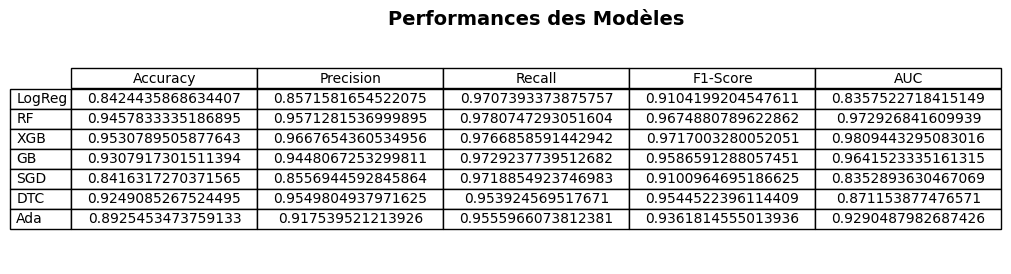

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Script pour générer et afficher un tableau des performances des modèles.
"""

import pandas as pd
import matplotlib.pyplot as plt

# Données de performance pour chaque modèle
data = {
    "LogReg": {
        "Accuracy": 0.8424435868634407,
        "Precision": 0.8571581654522075,
        "Recall": 0.9707393373875757,
        "F1-Score": 0.9104199204547611,
        "AUC": 0.8357522718415149
    },
    "RF": {
        "Accuracy": 0.9457833335186895,
        "Precision": 0.9571281536999895,
        "Recall": 0.9780747293051604,
        "F1-Score": 0.9674880789622862,
        "AUC": 0.972926841609939
    },
    "XGB": {
        "Accuracy": 0.9530789505877643,
        "Precision": 0.9667654360534956,
        "Recall": 0.9766858591442942,
        "F1-Score": 0.9717003280052051,
        "AUC": 0.9809443295083016
    },
    "GB": {
        "Accuracy": 0.9307917301511394,
        "Precision": 0.9448067253299811,
        "Recall": 0.9729237739512682,
        "F1-Score": 0.9586591288057451,
        "AUC": 0.9641523335161315
    },
    "SGD": {
        "Accuracy": 0.8416317270371565,
        "Precision": 0.8556944592845864,
        "Recall": 0.9718854923746983,
        "F1-Score": 0.9100964695186625,
        "AUC": 0.8352893630467069
    },
    "DTC": {
        "Accuracy": 0.9249085267524495,
        "Precision": 0.9549804937971625,
        "Recall": 0.953924569517671,
        "F1-Score": 0.9544522396114409,
        "AUC": 0.871153877476571
    },
    "Ada": {
        "Accuracy": 0.8925453473759133,
        "Precision": 0.917539521213926,
        "Recall": 0.9555966073812381,
        "F1-Score": 0.9361814555013936,
        "AUC": 0.9290487982687426
    }
}

# Création d'un DataFrame et transposition pour avoir les modèles en lignes
df = pd.DataFrame(data).T

# Affichage du tableau dans la console
print("Tableau des performances des modèles:")
print(df)

# Affichage graphique du tableau avec matplotlib
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Performances des Modèles", fontsize=14, fontweight='bold')
plt.show()


In [14]:
"""# Définir l'objectif de la fonction d'optimisation
def objective(trial):
    # Définir l'espace de recherche des hyperparamètres pour model 1 avec des intervalles dynamiques
    params = {
        "objective": "binary:logistic",  # Objectif de classification binaire
        "eval_metric": "auc",  # AUC comme métrique d'évaluation
        "max_depth": trial.suggest_int("max_depth", 3, 12),  # Profondeur maximale de l'arbre (entre 3 et 12)
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),  # Taux d'apprentissage (logarithmique)
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),  # Nombre d'estimateurs (entre 50 et 500)
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),  # Fraction des données pour chaque arbre
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),  # Fraction des caractéristiques par arbre
        "gamma": trial.suggest_int("gamma", 0, 5),  # Gamma (régularisation des arbres)
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Poids minimum des échantillons dans un nœud
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),  # Pas maximal pour mise à jour des poids
        "scale_pos_weight": trial.suggest_uniform("scale_pos_weight", 0.5, 2),  # Ajuste la balance des classes
        "lambda": trial.suggest_uniform("lambda", 0, 2),  # L2 regularization (entre 0 et 2)
        "alpha": trial.suggest_uniform("alpha", 0, 2),  # L1 regularization (entre 0 et 2)
        "random_state": 42  # Pour garantir la reproductibilité
    }

    # Entraîner le modèle avec les hyperparamètres choisis par Optuna
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_fusion, y_train)

    # Prédire et évaluer
    y_pred = model.predict_proba(X_test_fusion)[:, 1]  # Probabilités des classes positives
    return roc_auc_score(y_test, y_pred)  # AUC comme métrique de performance

# Lancer l'optimisation
study = optuna.create_study(direction="maximize")  # Maximiser l'AUC
study.optimize(objective, n_trials=50)

# Meilleurs paramètres trouvés
best_params = study.best_params
print("Meilleurs hyperparamètres :", best_params)

# Entraîner le modèle final avec les meilleurs hyperparamètres
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_fusion, y_train)

# Prédictions du modèle final
final_prob = final_model.predict_proba(X_test_fusion)[:, 1]

# Extraction des importances des features
importances = final_model.feature_importances_
features = X_train_fusion.columns

# Affichage des features les plus importantes
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features)
plt.title("Importance des Features avec XGBoost (modèle final)")
plt.show()

# Variation du seuil de décision
thresholds = np.linspace(0, 1, 50)
precisions = [precision_score(y_test, (final_prob >= t).astype(int), zero_division=0) for t in thresholds]
recalls = [recall_score(y_test, (final_prob >= t).astype(int), zero_division=0) for t in thresholds]
f1_scores = [f1_score(y_test, (final_prob >= t).astype(int), zero_division=0) for t in thresholds]

# Affichage des courbes
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, marker='o', linestyle='-', label='Precision')
plt.plot(thresholds, recalls, marker='o', linestyle='-', label='Recall')
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', label='F1-Score')
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.title("Impact du seuil de décision sur les métriques")
plt.legend()
plt.grid()
plt.show()

# Résumé des résultats
fusion_performance = {
    "Accuracy": accuracy_score(y_test, (final_prob >= 0.5).astype(int)),
    "Precision": precision_score(y_test, (final_prob >= 0.5).astype(int), zero_division=0),
    "Recall": recall_score(y_test, (final_prob >= 0.5).astype(int), zero_division=0),
    "F1-Score": f1_score(y_test, (final_prob >= 0.5).astype(int), zero_division=0),
    "AUC": roc_auc_score(y_test, final_prob)
}

print("\nPerformances du modèle final :")
print(fusion_performance)

# Enregistrement des résultats dans un fichier JSON
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
file_name = f"results_{chosen_metric}_{timestamp}.json"
results = {
    "chosen_metric": chosen_metric,
    "best_params": best_params,
    "fusion_performance": fusion_performance,
}

with open(file_name, "w") as f:
    json.dump(results, f, indent=4)

print(f"\nRésultats enregistrés dans {file_name}")"""

'# Définir l\'objectif de la fonction d\'optimisation\ndef objective(trial):\n    # Définir l\'espace de recherche des hyperparamètres pour model 1 avec des intervalles dynamiques\n    params = {\n        "objective": "binary:logistic",  # Objectif de classification binaire\n        "eval_metric": "auc",  # AUC comme métrique d\'évaluation\n        "max_depth": trial.suggest_int("max_depth", 3, 12),  # Profondeur maximale de l\'arbre (entre 3 et 12)\n        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),  # Taux d\'apprentissage (logarithmique)\n        "n_estimators": trial.suggest_int("n_estimators", 50, 500),  # Nombre d\'estimateurs (entre 50 et 500)\n        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),  # Fraction des données pour chaque arbre\n        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),  # Fraction des caractéristiques par arbre\n        "gamma": trial.suggest_int("gamma", 0, 5),  # Gamma (régularisation d